**Mount the drive for reading/loading the dataset stored in drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the zip file of dataset

In [ ]:
!unzip train.zip 

**Directory in which extracted dataset resides**

In [8]:
path_dataset = '/content/drive/MyDrive/NLP/Cats and Dogs Classification/Dataset'

**Directories where Train, Validation and Test data will be stored**

In [9]:
path_train_dataset = '/content/drive/MyDrive/NLP/Cats and Dogs Classification/train'
path_val_dataset = '/content/drive/MyDrive/NLP/Cats and Dogs Classification/validation'
path_test_dataset = '/content/drive/MyDrive/NLP/Cats and Dogs Classification/test'

**Import required libraries for writing dataset in drive in an organised manner**  

In [10]:
import os, shutil 

The files are named as 'type.num_file.jpg' and there are 12500 images per class numbered from 0-12499. We are using 10000 images (0-9999) per class for training, 2000 images (10000-11999) per class for validation and 500 images (12000-12499) per class for testing. 

src stores the filename of file *fname* prefixed with its source directory. dst stores the filename of file *fname* prefixed with destination directory. *shutil.copyfile(src,dst)* copies the file *fname* from *src* to *dst*.

In [25]:
fnames = ['cat.{}.jpg'.format(i) for i in range(10000)]
for fname in fnames:
  src = os.path.join(path_dataset, fname)
  dst = os.path.join(path_train_dataset+'/cats', fname)
  shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10000)]
for fname in fnames:
  src = os.path.join(path_dataset, fname)
  dst = os.path.join(path_train_dataset+'/dogs', fname)
  shutil.copyfile(src, dst)

This is for validation data. Same as training data.

In [26]:
fnames = ['cat.{}.jpg'.format(i) for i in range(10000,12000)]
for fname in fnames:
  src = os.path.join(path_dataset, fname)
  dst = os.path.join(path_val_dataset+'/cats', fname)
  shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10000,12000)]
for fname in fnames:
  src = os.path.join(path_dataset, fname)
  dst = os.path.join(path_val_dataset+'/dogs', fname)
  shutil.copyfile(src, dst)

This is for test data. Same as training and validation data.

In [27]:
fnames = ['cat.{}.jpg'.format(i) for i in range(12000,12500)]
for fname in fnames:
  src = os.path.join(path_dataset, fname)
  dst = os.path.join(path_test_dataset+'/cats', fname)
  shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(12000,12500)]
for fname in fnames:
  src = os.path.join(path_dataset, fname)
  dst = os.path.join(path_test_dataset+'/dogs', fname)
  shutil.copyfile(src, dst)

Check the number of samples in training, validation and test data for each class. *os.listdir(dir)* returns a list containing filenames of all the files present in directory *dir*

In [28]:
print('Total images in train:', len(os.listdir(path_dataset)))
print('Total cat images in train:', len(os.listdir(path_train_dataset+'/cats')))
print('Total dog images in train:', len(os.listdir(path_train_dataset+'/dogs')))
print('Total cat images in validation:', len(os.listdir(path_val_dataset+'/cats')))
print('Total dog images in validation:', len(os.listdir(path_val_dataset+'/dogs')))
print('Total cat images in test:', len(os.listdir(path_test_dataset+'/cats')))
print('Total dog images in test:', len(os.listdir(path_test_dataset+'/dogs')))

Total images in train: 25000
Total cat images in train: 10000
Total dog images in train: 10000
Total cat images in validation: 2000
Total dog images in validation: 2000
Total cat images in test: 500
Total dog images in test: 500


Since the samples are RGB images and each cell of eavery band has value between 0-255 so we are mapping it between 0-1 because neural nets prefer small values.

In [29]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Since the dataset is large and it is not possible to load all of the dataset at once in memory so the dataset will be loaded in batches. And the class labels are generated according to the number of folders in the directory. The image will be resized to 150x150 after it gets loaded into memory. *flow_from_directory(path_train_dataset, target_size=(150, 150))* does this task. 

Since there are 2 folders in *train*,*validation* and *test* folders, the output shows 2 classes. There are 20000 images in *train* (10000 each in *cats* and *dogs* folder) so output shows 20000 images.Similarly output shows 4000 and 1000 images for *validation* and *test* folders. 

In [30]:
train_generator = train_datagen.flow_from_directory(path_train_dataset, target_size=(150, 150))
validation_generator = val_datagen.flow_from_directory(path_val_dataset, target_size=(150, 150))
test_generator = test_datagen.flow_from_directory(path_test_dataset, target_size=(150, 150))

Found 20000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## **Build the neural network**

This cell builds our neural network. First the required libraries are imported. 

Then we are building a sequential model (i.e. the layers are added one after another). Same can be built using functional model too.

The first layer takes input image of size 150x150 is input layer and applies 2D convolution. There are 32 3x3 filters in this layer. The activation function used here is *ReLU* which is defined as *f(x) = max(0,x)*. The next layer is a pooling layer which reduces the size of feature map generated by Convolution layer by half (Since we have used 2x2 pooling). This is followed by a dropout layer to avoid overfitting our model. The dropout parameter is 0.25 which means random 25% neurons will be switched off (output nullified).

This output feature map is used as input to next convolution layer which has 64 3x3 filters. The activation, pooling and dropout operations are same as above. The next two layers have 128 3x3 kernels with same activation function and pooling and dropout parameters.

Then we have a flatten layer which converts the 2D output of previous layer to 1D vector. Which is then connected to a dense layer of 512 units. In dense layer the every neuron has every output of previous layer as input. This layer also uses *ReLU* activation function.

Then we have an output dense layer of 2 units (because we have 2 classes). This layer uses *Softmax* as activation function (because we need output in terms of probabilities). The assigned class is the one with higher probability.

In [31]:
from keras import layers,models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

This generates the summary of the model specifying the output shapes and parameters to be learned at each layer. 

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       7

Here the model is compiled and the loss function we are using is *categorical cross-entropy*. The metric for evaluation is *accuracy* i.e. percent of correctly predicted labels out of total number of predictions. The optimizer used is *adam*.

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## **Training the neural network**

Here the model is trained using the training dataset and validated on validation dataset. We are training it for 20 epochs. Training and Validation loss and accuracy are shown at every step.

In [34]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
625/625 [==============================] - 152s 191ms/step - loss: 0.6399 - accuracy: 0.6165 - val_loss: 0.5435 - val_accuracy: 0.7258
Epoch 2/20
625/625 [==============================] - 116s 185ms/step - loss: 0.5366 - accuracy: 0.7325 - val_loss: 0.4948 - val_accuracy: 0.7667
Epoch 3/20
625/625 [==============================] - 118s 189ms/step - loss: 0.4811 - accuracy: 0.7684 - val_loss: 0.4337 - val_accuracy: 0.7875
Epoch 4/20
625/625 [==============================] - 118s 189ms/step - loss: 0.4463 - accuracy: 0.7928 - val_loss: 0.3976 - val_accuracy: 0.8135
Epoch 5/20
625/625 [==============================] - 118s 189ms/step - loss: 0.4056 - accuracy: 0.8181 - val_loss: 0.4106 - val_accuracy: 0.7968
Epoch 6/20
625/625 [==============================] - 120s 192ms/step - loss: 0.3695 - accuracy: 0.8363 - val_loss: 0.3736 - val_accuracy: 0.8328
Epoch 7/20
625/625 [==============================] - 126s 202ms/step - loss: 0.3500 - accuracy: 0.8467 - val_loss: 0.3115 -

Here we have plotted the training phase of the model. The two plots are *epochs vs accuracy* and *epochs vs loss*.

Text(0.5, 1.0, 'Training and Validation Accuracy')

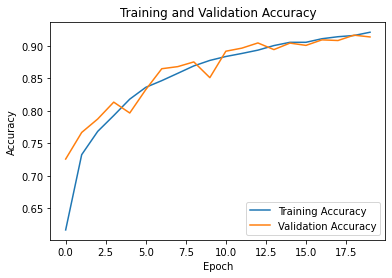

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

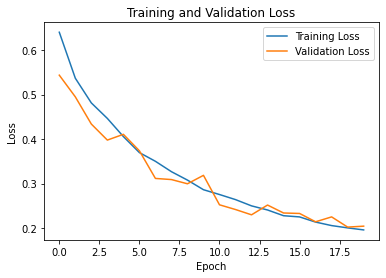

In [36]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

Saving the trained model at a given location

In [37]:
model.save('/content/drive/MyDrive/NLP/Cats and Dogs Classification'+'/Cats_and_Dogs_Classifier.h5')

Loading the saved model and displaying the summary to be sure it is the same model

In [38]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/NLP/Cats and Dogs Classification'+'/Cats_and_Dogs_Classifier.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       7

Evaluate the model on test dataset. Our model achieved an accuracy of 92.29% at fairly low *categorical cross entropy* loss of 0.1905.  

In [39]:
model.evaluate(test_generator)

32/32 [==============================] - 5s 143ms/step - loss: 0.1905 - accuracy: 0.9230


[0.1904815286397934, 0.9229999780654907]

Location of Cat and Dog Image on which prediction has to be made

In [40]:
img_path = '/content/drive/MyDrive/NLP/Cats and Dogs Classification/'

Load the Cat image from drive and resize it to 150x150 (because our model requires 150x150 input size). Then the image is converted to a matrix. Then one extra dimesion is added for making predictions. Then the pixel values of 0-255 is mapped to range 0-1. 

The link for image is [Cat Image](https://static.scientificamerican.com/sciam/cache/file/92E141F8-36E4-4331-BB2EE42AC8674DD3_source.jpg?w=590&h=800&1966AE6B-E8E5-4D4A-AACA385519F64D03)

In [107]:
from keras.preprocessing import image
import numpy as np
img = image.load_img(img_path+'/Cat.jpg', target_size=(150, 150))
img_tensor_cat = image.img_to_array(img)
img_tensor_cat = np.expand_dims(img_tensor_cat, axis=0)
img_tensor_cat /= 255.
img_tensor_cat.shape

(1, 150, 150, 3)

The cat image is shown using matplotlib library

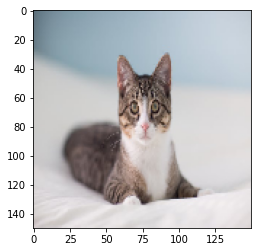

In [43]:
plt.imshow(img_tensor_cat[0])
plt.show()

Prediction is made on above image. It can be seen that value at label 0 is more than value at label 1. So, this image belongs to class 0 i.e. *cat*.

In [108]:
model.predict(img_tensor_cat)

array([[1.0000000e+00, 4.7702045e-08]], dtype=float32)

Class is 0 i.e. *Cat*

In [114]:
np.argmax(model.predict(img_tensor_cat))

0

Load the Dog image from drive and resize it to 150x150 (because our model requires 150x150 input size). Then the image is converted to a matrix. Then one extra dimesion is added for making predictions. Then the pixel values of 0-255 is mapped to range 0-1. 

The link for image is [Dog Image](https://ichef.bbci.co.uk/news/976/cpsprodpb/4F09/production/_115133202_002716794.jpg)

In [44]:
from keras.preprocessing import image
import numpy as np
img = image.load_img(img_path+'/Dog.jpg', target_size=(150, 150))
img_tensor_dog = image.img_to_array(img)
img_tensor_dog = np.expand_dims(img_tensor_dog, axis=0)
img_tensor_dog /= 255.
img_tensor_dog.shape

(1, 150, 150, 3)

The cat image is shown using matplotlib library

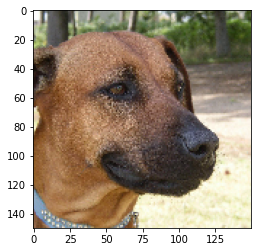

In [45]:
plt.imshow(img_tensor_dog[0])
plt.show()

Prediction is made on above image. It can be seen that value at label 1 is more than value at label 0. So, this image belongs to class 1 i.e. *dog*.

In [109]:
model.predict(img_tensor_dog)

array([[0.47745302, 0.522547  ]], dtype=float32)

Class is 1 i.e. *Dog*

In [115]:
np.argmax(model.predict(img_tensor_dog))

1

Now we will plot the output of every layer for both cat and dog images. *layer.output* provides output of layer *layer*. *activation_model* is an object which will give outputs of all the layers.

In [54]:
from keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [112]:
activations = activation_model.predict(img_tensor_cat)
activations

[array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0.

Checking the output shape of first layer if it matches with the one in model summary.

In [99]:
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 148, 148, 32)

Showing the 5th channel out of 32 channels of output of first layer.

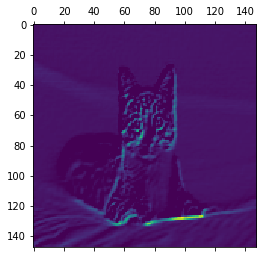

In [86]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')

Plots of all the channels of outputs of all the layers before flatten layer (After that inputs/outputs to subsequent layers become one dimensional).  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


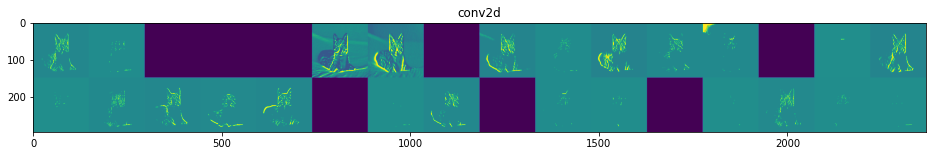

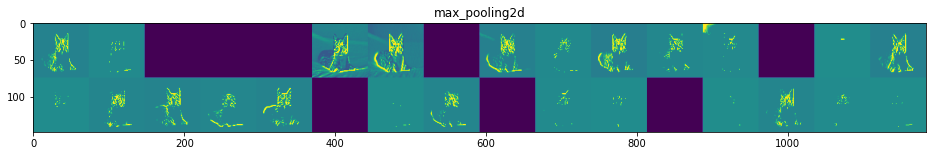

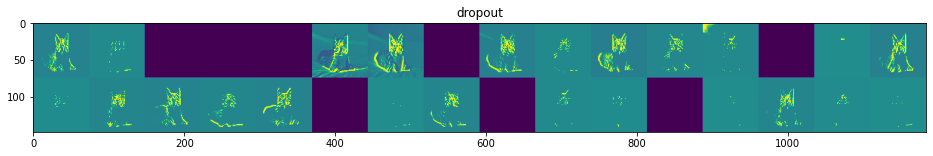

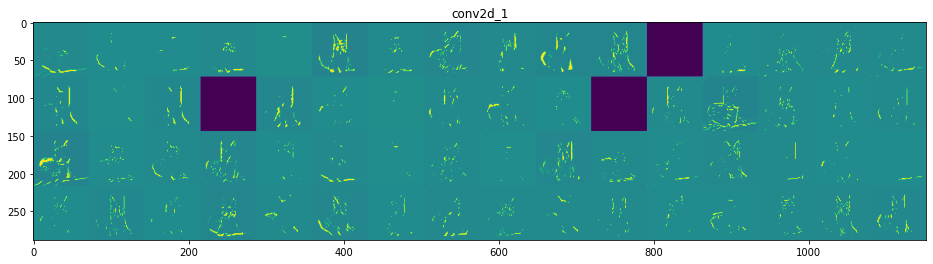

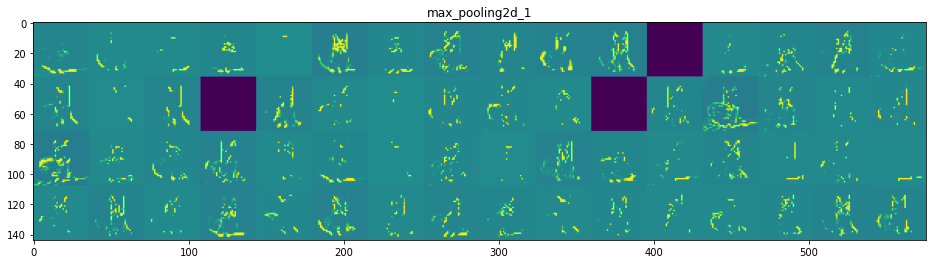

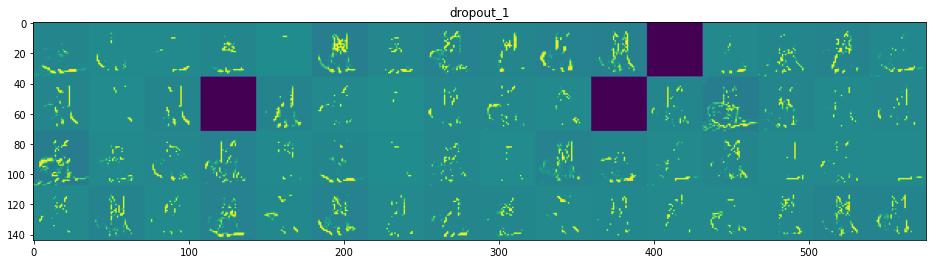

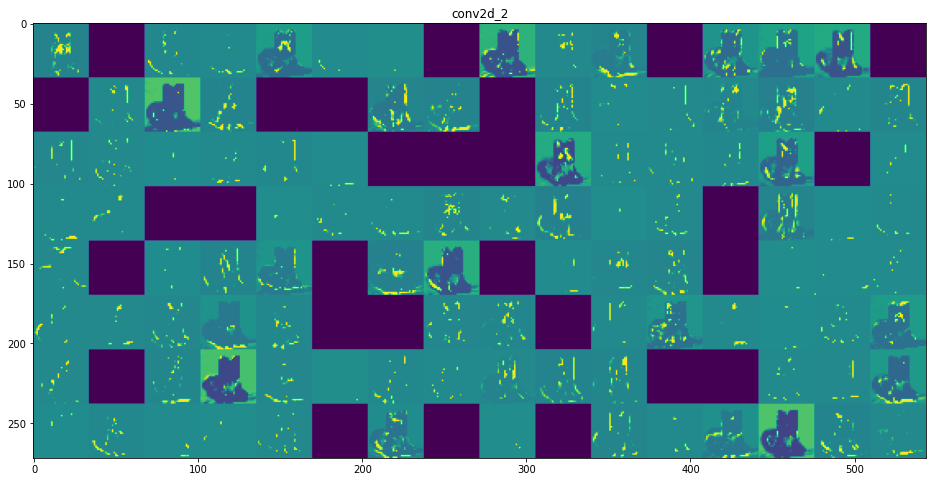

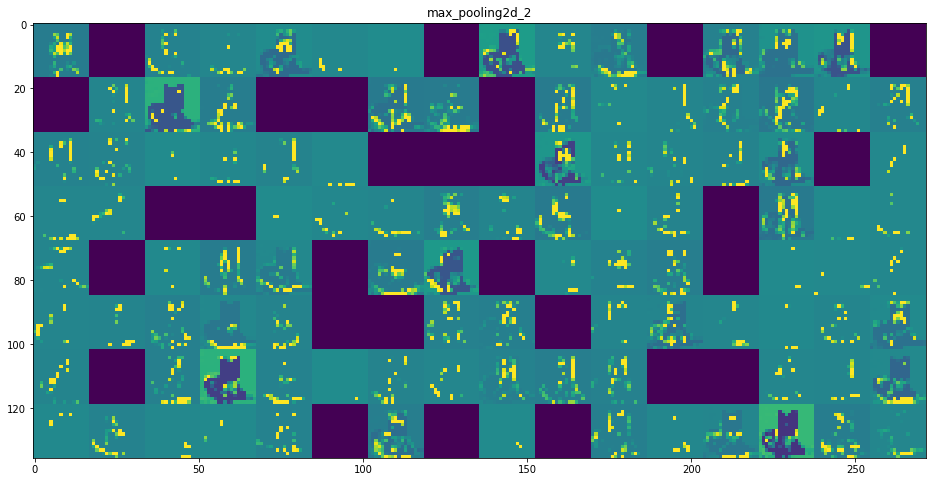

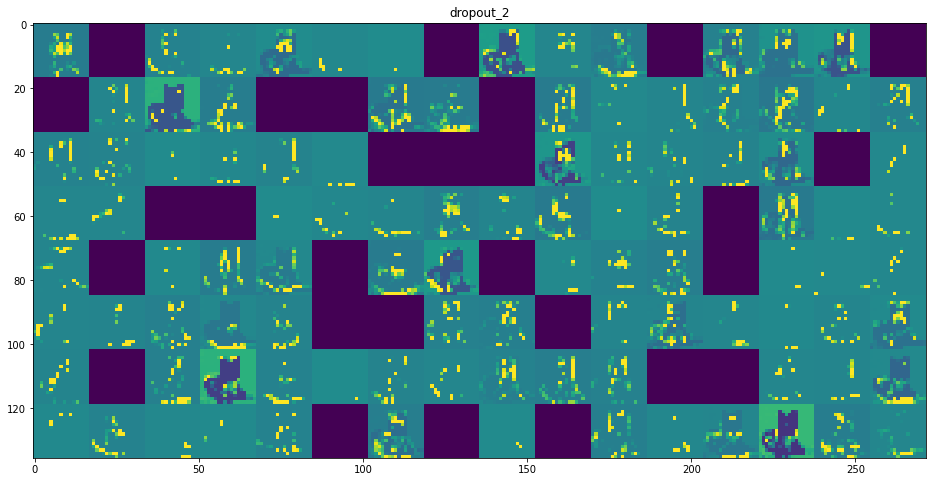

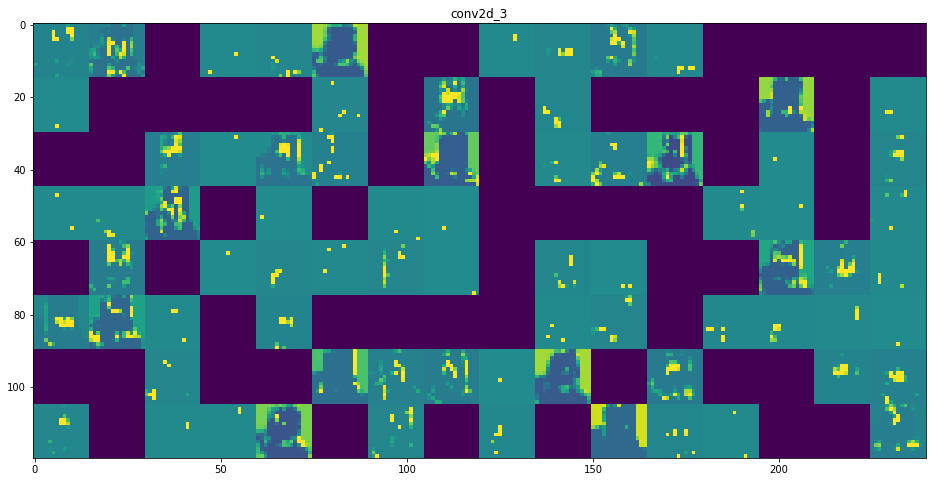

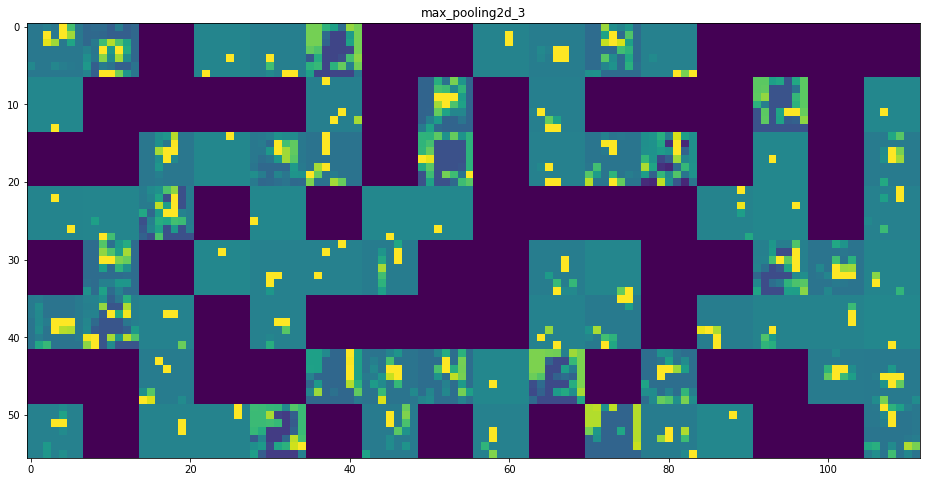

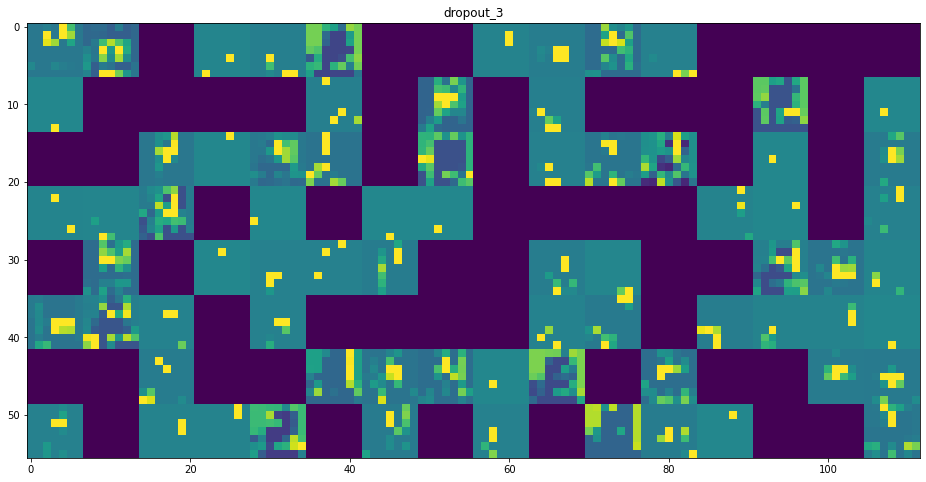

In [116]:
layer_names = []
for layer in model.layers[:12]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[3]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,:, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

Doing same thing for dog image

In [101]:
activations = activation_model.predict(img_tensor_dog)
activations

[array([[[[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.1310978 ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.0349349 ,
           0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.08086677,
   

In [102]:
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 148, 148, 32)

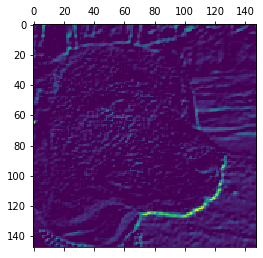

In [103]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


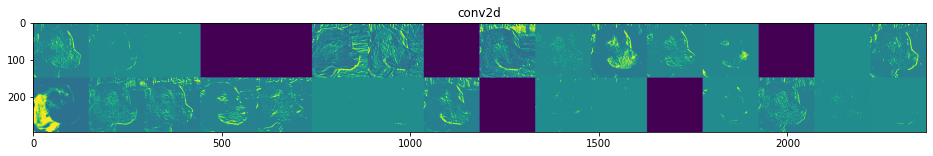

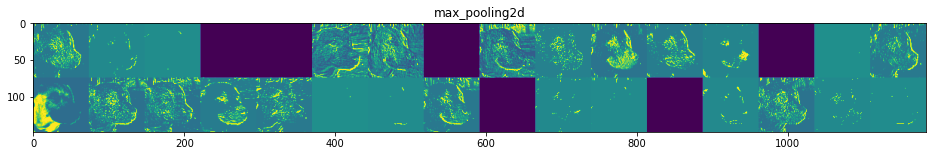

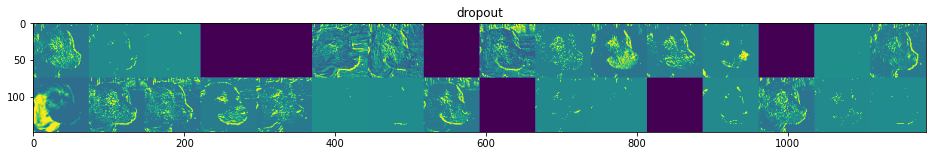

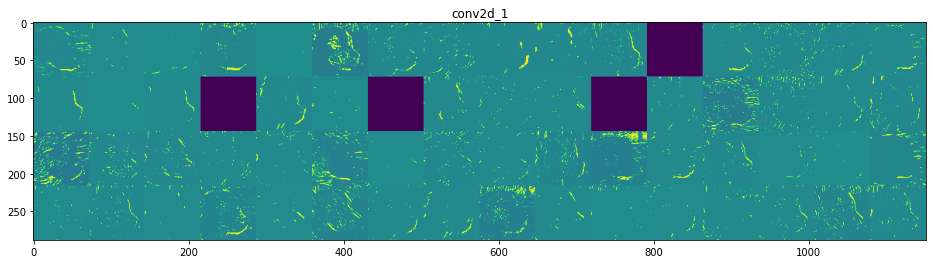

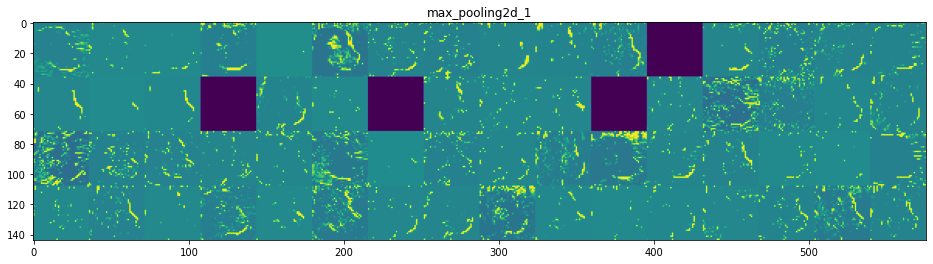

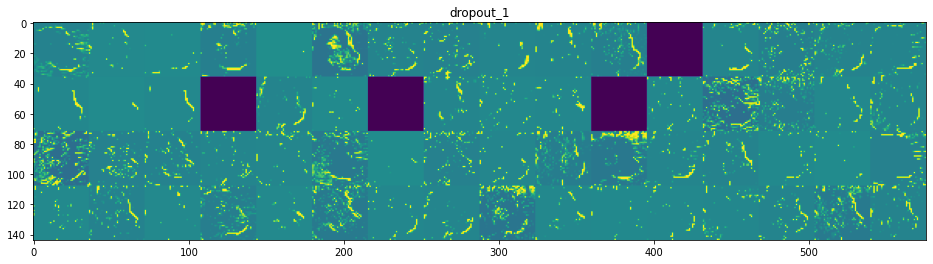

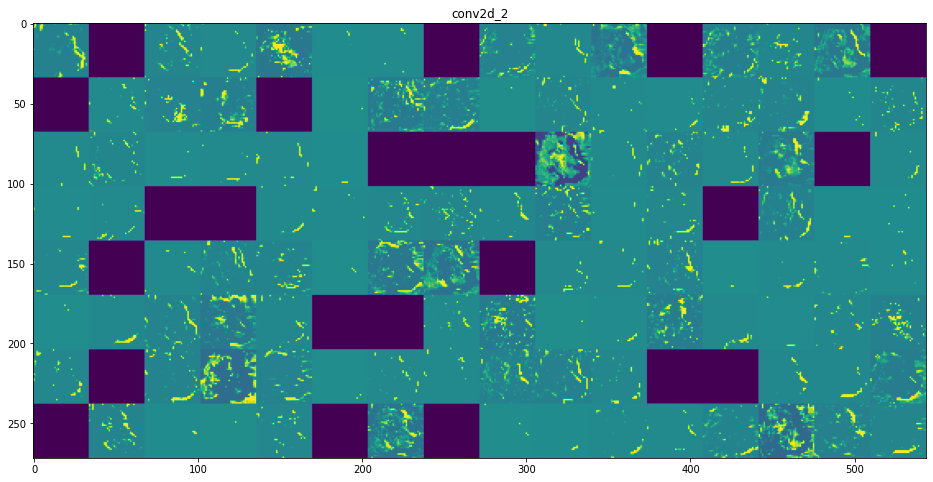

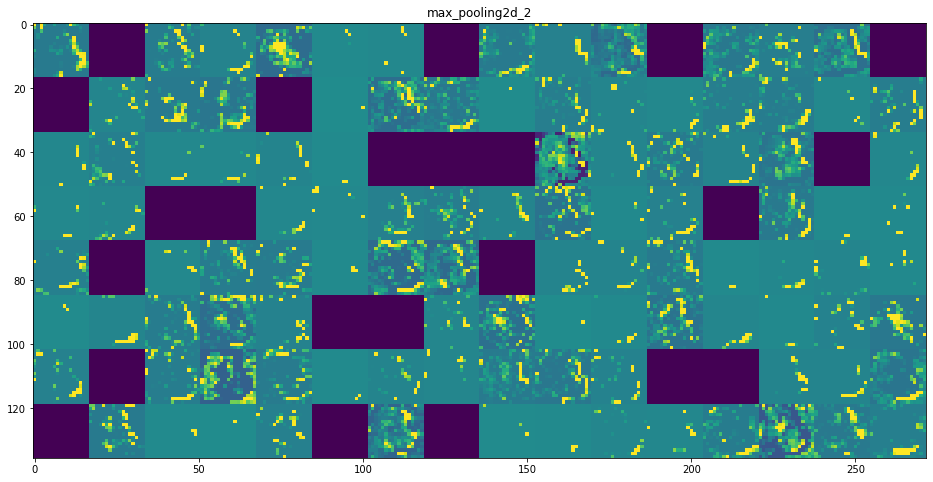

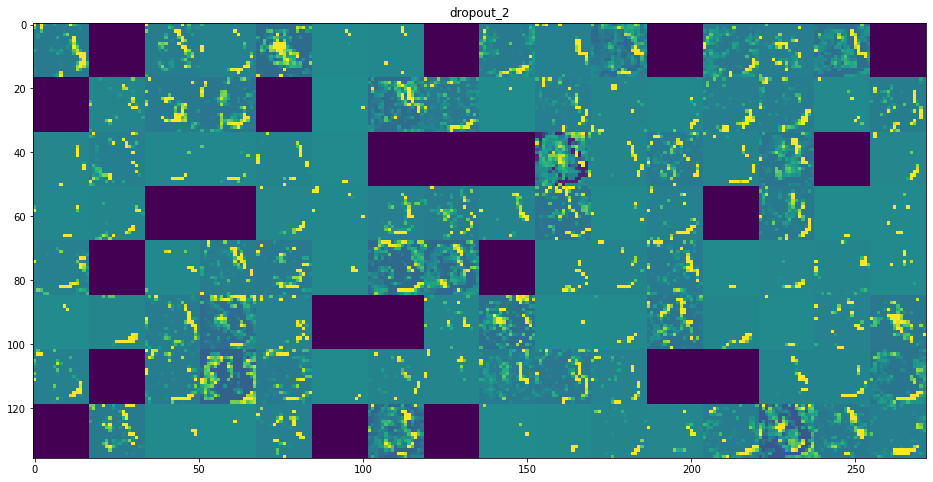

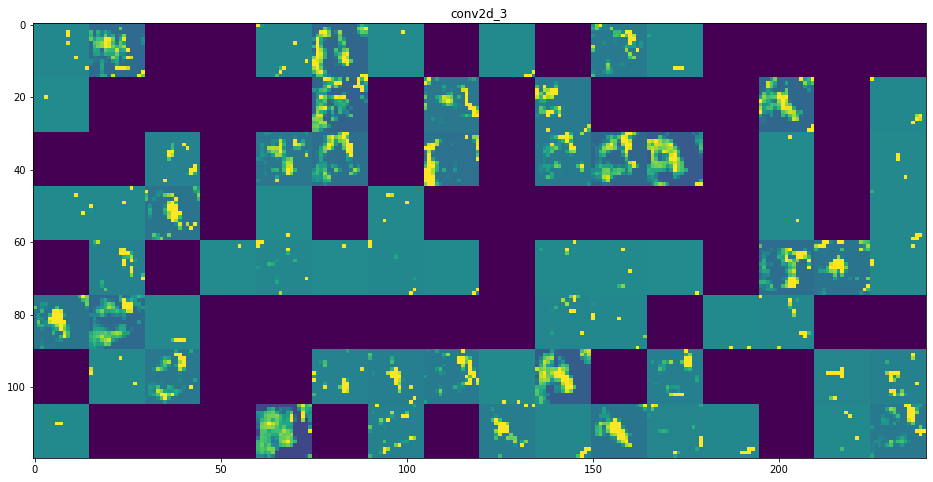

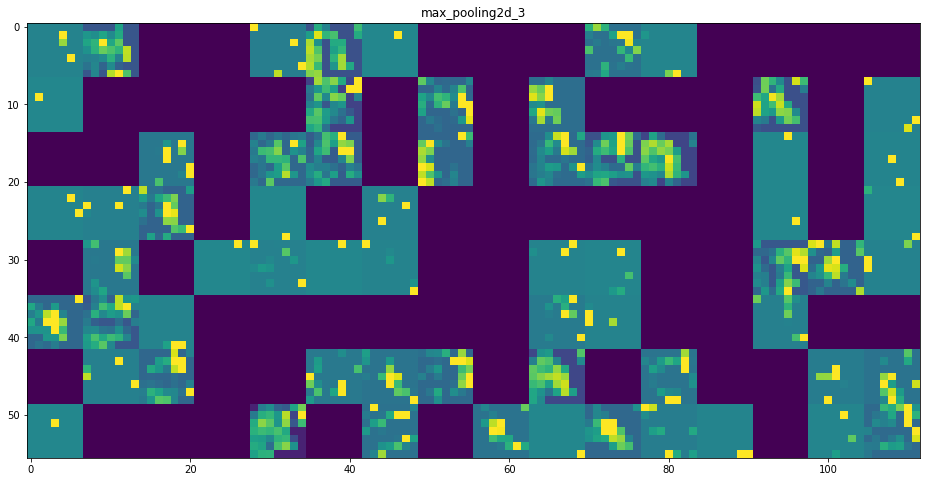

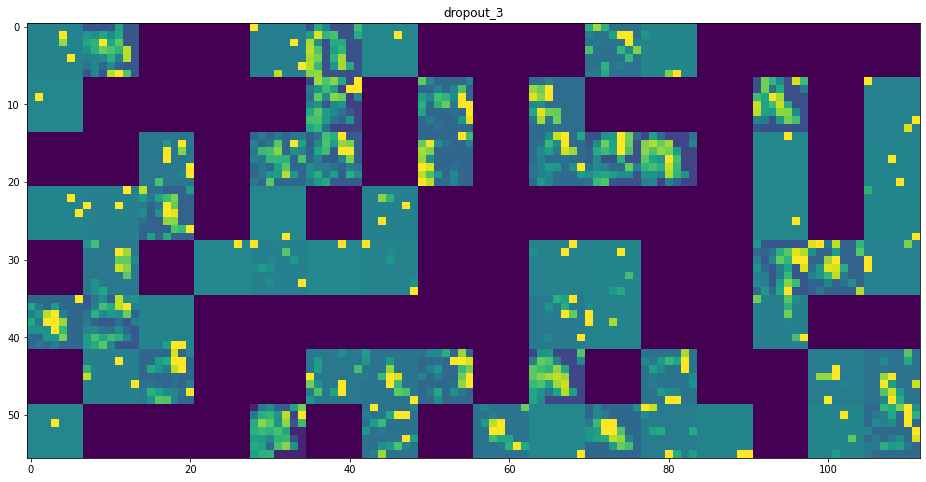

In [104]:
layer_names = []
for layer in model.layers[:12]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[3]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,:, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')